In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load the dataset

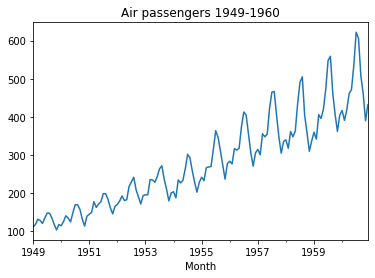

In [2]:
df = pd.read_csv("../datasets/AirPassengers.csv", index_col=[0], parse_dates=[0]) # load air passengers data
ts_data = df["#Passengers"] # Get the data as a Series
# plot the data
ts_data.plot()
plt.title("Air passengers 1949-1960")
plt.show()

## Data preprocessing

In [3]:
# Train-test split

# I will use all the data for training and keep the last two years (1959,1960) as val and test sets respectively
train = ts_data[:-24]
test = ts_data[-24:]
print("Amount of training data:", len(train))
print(train.head(2), "\n")
print("Amount of testing data:", len(test))
print(test.head(2), "\n")

# Data scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.fit_transform(test.values.reshape(-1,1))

Amount of training data: 120
Month
1949-01-01    112
1949-02-01    118
Name: #Passengers, dtype: int64 

Amount of testing data: 24
Month
1959-01-01    360
1959-02-01    342
Name: #Passengers, dtype: int64 



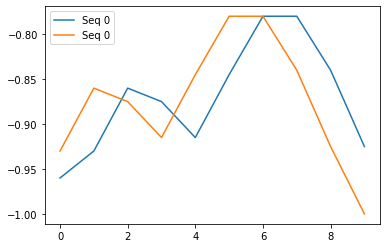

In [4]:
# Transforming data into sequences

# In order for a LSTM network to make use of TS data, they must first be transformed into sequences
def transform_ts_to_seq(data, seq_len=10):
    inout_seq = []
    
    for i in range(len(data)-seq_len):
        x_i = data[i : i+seq_len]
        y_i = data[i+seq_len : i+seq_len+1]
        x_arr = np.array(x_i).reshape(-1, seq_len)
        y_arr = np.array(y_i).reshape(-1, 1)
        x_var = Variable(torch.from_numpy(x_arr).float())
        y_var = Variable(torch.from_numpy(y_arr).float())
        inout_seq.append((x_var,y_var))

    return inout_seq
    
# Run the function for each part of the dataset
train_data = transform_ts_to_seq(train_scaled)
test_data = transform_ts_to_seq(test_scaled)

# Plotting the first two sequences to understand the network input
plt.plot(train_data[0][0].tolist()[0], label="Seq 0")
plt.plot(train_data[1][0].tolist()[0], label="Seq 0")
plt.legend()
plt.show()

## Building the LSTM Network

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, future=0, y=None):
        outputs = []
        
        # Resets the state of the LSTM cell
        # We want to keep the state until the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            #print(i, input_t)
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs = [output]
            
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]] # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs = [output]
            
        outputs = torch.stack(outputs,1).squeeze(2)
        return outputs

In [6]:
# Create the model, loss function and the optimizer
lstm_model = Model(1, 21, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
lstm_model

Model(
  (lstm): LSTMCell(1, 21)
  (linear): Linear(in_features=21, out_features=1, bias=True)
)

## Train and then evaluate the model

In [7]:
# Train the model on the training data
epochs = 50
for i in range(epochs):    
    for seq, labels in train_data:
        optimizer.zero_grad()
        y_pred = lstm_model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000888
epoch:  26 loss: 0.01828602
epoch:  49 loss: 0.0056589120


In [8]:
y_test_data = []
for x_test, y_test in test_data:
    y_test_data.append(y_test[0][0])
    
preds = []
lstm_model.eval()
for i in range(len(test_data)):
        with torch.no_grad():
            y_pred_test = lstm_model(test_data[i][0])
            preds.append(lstm_model(test_data[i][0])[0][0])

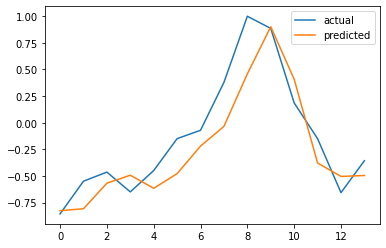

Mean squared error of predictions is: 0.06214923
Mean absolute error of predictions is: 0.2076501
Root mean squared error of predictions is: 0.24929747


In [9]:
plt.plot(y_test_data, label="actual")
plt.plot(preds, label="predicted")
plt.legend()
plt.show()

mse = mean_squared_error(y_test_data, preds)
mae = mean_absolute_error(y_test_data, preds)
print("Mean squared error of predictions is:", mse)
print("Mean absolute error of predictions is:", mae)
print("Root mean squared error of predictions is:", np.sqrt(mse))

## Try out the model and predict for the next three years

In [10]:
wanted_future_steps = 36
predictions = []

for i in range(wanted_future_steps):
    with torch.no_grad():
        predictions.append(lstm_model(test_data[13][0], i)[0][0])
        
real_value_predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
real_value_predictions = [val[0] for val in real_value_predictions]

Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64


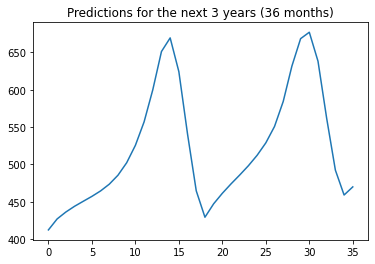

In [11]:
print(ts_data[-5:])
plt.plot(real_value_predictions)
plt.title("Predictions for the next 3 years (36 months)")
plt.show()

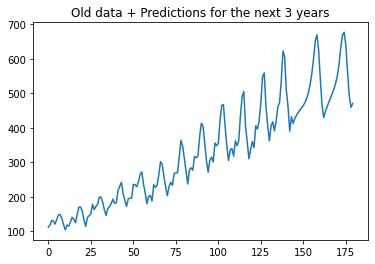

In [12]:
old_data_with_preds = ts_data.values.tolist() + real_value_predictions
plt.plot(old_data_with_preds)
plt.title("Old data + Predictions for the next 3 years")
plt.show()